<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Physics_Denoising_EM_Data_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Noise removal with autoencoders

In this notebook, we attempt to remove noise to obtain clean images using autoencoders.

The surfaces of many particles are extremely rough. As a result, various imaging techniques struggle to obtain clean images due to a common interference phenomenon called speckle.

Speckle is a granular interference that inherent and degrades the quality of the active radar, synthetic aperture radar (SAR), medical ultrasound, and optical coherence tomography images. This unwanted modification of the ground truth makes the recorded data noisy.  

In this example, we remove the speckle using an autoencoder.



In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Physics')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Physics/"
files_to_download = ["speckles.npz"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

The data is stored in 'Physics/speckles.npz', containing 25484, gray-scale, 64 × 64 images. We will use 80% of images to train neural networks and the rest of them to evaluate the neural networks. The details of the data can be found in https://nbviewer.org/github/DeepLearningForPhysicsResearchBook/deep-learning-physics/blob/main/Exercise_17_1.ipynb.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
f = np.load(join(data_path, 'Physics/speckles.npz'))

noised_img = f['speckle_images']
clean_img = f['target_images']

max_pixel = np.max(noised_img, axis=(1, 2, 3), keepdims=True)

noised_img = noised_img/max_pixel
clean_img = clean_img/max_pixel

n_train = int(len(noised_img)*0.8)

x_train = noised_img[:n_train]
y_train = clean_img[:n_train]


x_test = noised_img[n_train:]
y_test = clean_img[n_train:]
```
    
</p>
</details>

In [4]:
f = np.load(join(data_path, 'Physics/speckles.npz'))

noised_img = f['speckle_images']
clean_img = f['target_images']

max_pixel = np.max(noised_img, axis=(1, 2, 3), keepdims=True)

noised_img = noised_img/max_pixel
clean_img = clean_img/max_pixel

n_train = int(len(noised_img)*0.8)

x_train = noised_img[:n_train]
y_train = clean_img[:n_train]


x_test = noised_img[n_train:]
y_test = clean_img[n_train:]

In [5]:
# define image size
IMG_HEIGHT = 64
IMG_WIDTH = 64
N_CHANNELS = 1
N_CLASSES = 2


# print
print("Number of training data: %d" % len(x_train))
print("Number of test data: %d" % len(x_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))

Number of training data: 20387
Number of test data: 5097
Image pixels: (64, 64)
Number of channels: 1


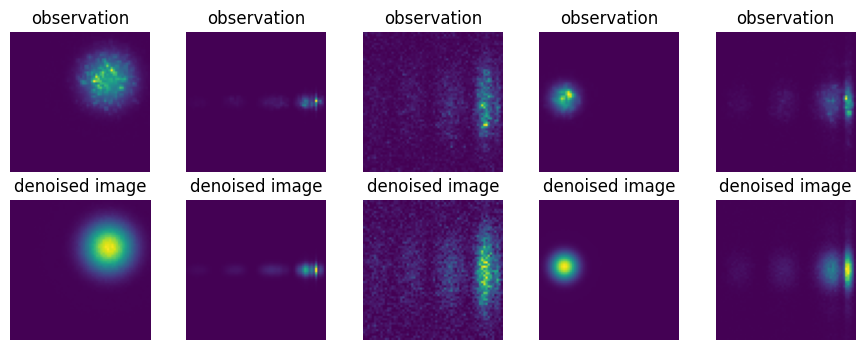

In [6]:
fig, axes = plt.subplots(2, 5, figsize = (11, 4))
for i in range(5):
    rnd_idx = np.random.choice(len(x_train), 1)[0]
    axes[0][i].imshow(x_train[rnd_idx].reshape(64, 64))
    axes[0][i].set_title('observation')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_train[rnd_idx].reshape(64, 64))
    axes[1][i].set_title('denoised image')
    axes[1][i].axis('off')

---

# 2. Build the network

The task is to build and train a convolutional autoencoder to remove speckle in images

### The encoder

The encoder contains three convolutional layers, an input layer with size 64$\times$64$\times$1 and one dense layer with size 128:

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the encoder
image_input = keras.Input(shape=(64, 64, 1))
#x = layers.Flatten()(image_input)
x = layers.Conv2D(32, 4, 2, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
latent_output = layers.Dense(128)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()
```
    
</p>
</details>

In [7]:
fig, axes = plt.subplots(2, 5, figsize = (11, 4))
for i in range(5):
    rnd_idx = np.random.choice(len(x_train), 1)[0]
    axes[0][i].imshow(x_train[rnd_idx].reshape(64, 64))
    axes[0][i].set_title('observation')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_train[rnd_idx].reshape(64, 64))
    axes[1][i].set_title('denoised image')
    axes[1][i].axis('off')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,720 (2.19 MB)

 Trainable params: 574,464 (2.19 MB)

 Non-trainable params: 256 (1.00 KB)

### The decoder

The decoder contains three transposed convolutional layers and one dense layer that are reciprocal to those of the encoders and one convolutional layer, outputing denoised images with the same size as the input images:

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the decoder
latent_input = keras.Input(shape=(128))
x = layers.Dense(4096)(latent_input)
x = layers.Reshape((8, 8, 64), input_shape=(4096,))(x)
x = layers.Conv2DTranspose(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
image_output = layers.Conv2D(1, 3, padding = 'same')(x)

decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()
```
    
</p>
</details>

In [9]:
# build the decoder
latent_input = keras.Input(shape=(128,))
x = layers.Dense(4096)(latent_input)
x = layers.Reshape((8, 8, 64), input_shape=(4096,))(x)
x = layers.Conv2DTranspose(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
image_output = layers.Conv2D(1, 3, padding = 'same')(x)

decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        16,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,001 (2.46 MB)

 Trainable params: 643,745 (2.46 MB)

 Non-trainable params: 256 (1.00 KB)

### The autoencoder

Joining up the encoder and the decoder, we obtain the AE network:

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the AE
image_input = keras.Input(shape=(64, 64, 1))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
```
    
</p>
</details>

In [10]:
# build the AE
image_input = keras.Input(shape=(64, 64, 1))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 128)            │       574,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 64, 64, 1)      │       644,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,218,721 (4.65 MB)

 Trainable params: 1,218,209 (4.65 MB)

 Non-trainable params: 512 (2.00 KB)

### Train the autoencoder

In [11]:
# train the AE
ae_model.fit(x_train, y_train, epochs=10, batch_size=64)


Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0409 - mse: 0.0409
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0027 - mse: 0.0027
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0020 - mse: 0.0020
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0017 - mse: 0.0017
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0016 - mse: 0.0016
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0014 - mse: 0.0014
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0013 - mse: 0.0013
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0013 - mse: 0.0013
Epoch 9/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0012 - mse: 0.0012
Epoch 10/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0012 - mse: 0.0012


---

# 3. Analyse results

160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


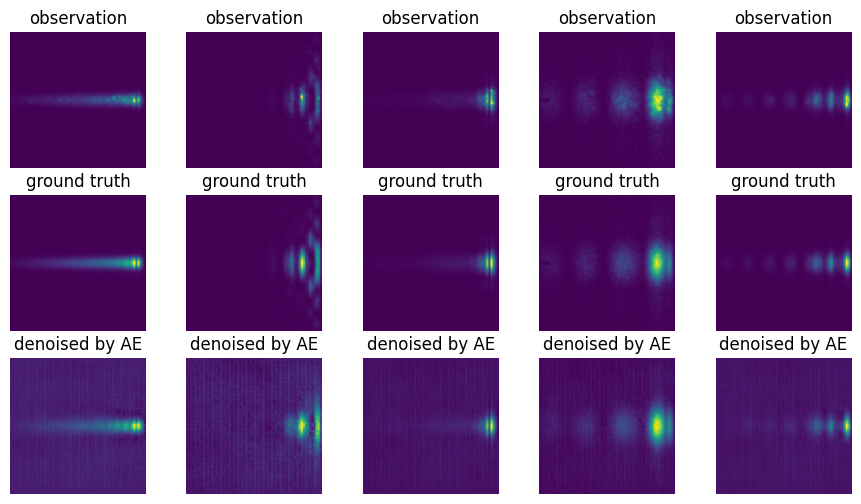

In [12]:
y_denoised = ae_model.predict(x_test)


fig, axes = plt.subplots(3, 5, figsize = (11, 6))
for i in range(5):
    rnd_idx = np.random.choice(len(x_test), 1)[0]
    axes[0][i].imshow(x_test[rnd_idx].reshape(64, 64))
    axes[0][i].set_title('observation')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_test[rnd_idx].reshape(64, 64))
    axes[1][i].set_title('ground truth')
    axes[1][i].axis('off')
    axes[2][i].imshow(y_denoised[rnd_idx].reshape(64, 64))
    axes[2][i].set_title('denoised by AE')
    axes[2][i].axis('off')

---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model));
* Change the architeture and activation functions of neural networks to improve the performance
* Add noise to input layer to make the network more robust to noise